In [1]:
import os
import copy

import numpy as np

from nems import Model, visualization

In [5]:
X=np.random.randn(500,2)
Y = X[:,:1]/2 + np.random.randn(X.shape[0],1)/100

#modelspec = 'wc.2x2-wc.2x1'   # works fine
#modelspec = 'wc.2x2-fir.1x2'   # gives sign flip
modelspec = 'fir.1x2'   # behaves weirdly

reps=5
cc=np.zeros(reps)
nmse=np.zeros(reps)
save_models0=[]
save_models=[]

for i in range(reps):
    model = Model.from_keywords(modelspec)
    model.sample_from_priors();
    save_models0.append(copy.deepcopy(model))
    
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 1e-2, 'epochs': 1000}
    #model = model.fit(input=np.expand_dims(X, axis=0),
    #          target=np.expand_dims(Y, axis=0), backend='tf',
    #          fitter_options=fitter_options,
    #          batch_size=None)
    
    # uncomment to run in scipy -- works fine
    fitter_options={'cost_function': 'nmse', 'options': {'ftol': 1e-5, 'maxiter': 100}}
    model=model.fit(input=X, target=Y, backend='scipy',
          fitter_options=fitter_options)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X)
    cc[i] = np.corrcoef(prediction[:, 0], Y[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y) / np.std(Y)
    save_models.append(model)


Epoch 0
        Iteration 0, error is: 0.03107172...
        Iteration 5, error is: 0.02045605...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Epoch 0
        Iteration 0, error is: 0.03107172...
        Iteration 5, error is: 0.02045605...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Epoch 0
        Iteration 0, error is: 0.03107172...
        Iteration 5, error is: 0.02045605...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Epoch 0
        Iteration 0, error is: 0.03107172...
        Iteration 5, error is: 0.02045605...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Epoch 0
        Iteration 0, error is: 0.03107172...
        Iteration 5, error is: 0.02045605...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [6]:
cc,nmse

(array([0.9997909, 0.9997909, 0.9997909, 0.9997909, 0.9997909]),
 array([0.02044871, 0.02044871, 0.02044871, 0.02044871, 0.02044871]))

In [7]:
model.layers[0].coefficients

array([[ 0.499744  , -0.00080836]])

In [8]:
# load data (download if necessary)
signals_dir = "/auto/data/nems_db/recordings"
basename = 'TAR010c-18-2.npz'
datafile = os.path.join(signals_dir, basename)

if not os.path.exists(datafile):
    print(f"Need to download demo data file {datafile}")
    import requests
    prefix = 'https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/'
    uri = prefix + basename
    r = requests.get(uri, stream=True)
    with open(datafile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
d = np.load(datafile)

cellid = 'TAR010c-18-2'
fs = 100
X_est=d['X_est']
Y_est=d['Y_est']
X_val=d['X_val']
Y_val=d['Y_val']

In [9]:
# normalize stimulus peak to 1
X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

In [10]:
modelspec = 'wc.18x1-fir.15x1-relu.1.o.s'
modelspec = 'wc.18x2-fir.15x2-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.sample_from_priors();

## Scipy backend fit

In [5]:
model_sci = copy.deepcopy(model0)

print('Backend: scipy, Fitting without NL ...')
model_sci.layers[-1].skip_nonlinearity()
fitter_options={'cost_function': 'nmse', 'options': {'ftol': 1e-5, 'maxiter': 100}}
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

print('Backend: scipy, Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
fitter_options['options']['ftol'] = 1e-6

model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

Backend: scipy, Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00297111...
        Iteration 5, error is: 0.98405254...
        Iteration 10, error is: 0.94478754...
        Iteration 15, error is: 0.91869088...
        Iteration 20, error is: 0.91195483...
        Iteration 25, error is: 0.90757063...
        Iteration 30, error is: 0.90633807...
        Iteration 35, error is: 0.90599271...
        Iteration 40, error is: 0.90567305...
        Iteration 45, error is: 0.90547887...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Backend: scipy, Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.89734182...
        Iteration 5, error is: 0.88564702...
        Iteration 10, error is: 0.88180929...
        Iteration 15, error is: 0.87707011...
        Iteration 20, error is: 0.87582863...
        Iteration 25, error is: 0.87517524...
        Iteration 30, error is: 0.87448648...
        Iteration 35, error is: 0.87398

prediction correlation: 0.606


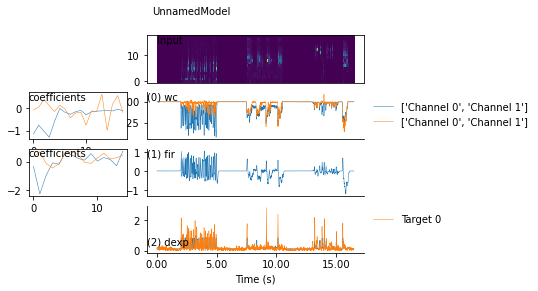

In [6]:
prediction = model_sci.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_sci, X_val, target=Y_val, sampling_rate=fs);

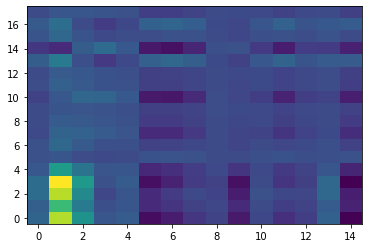

In [7]:
visualization.model.simple_strf(model_sci);

## TF backend fit

In [9]:
model_tf = model0.copy()

fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 150,
                  'early_stopping_tolerance': 5e-4, 'validation_split': 0.0, 
                  'learning_rate': 5e-3, 'epochs': 2000}

print('Backend: tf, Fitting without NL ...')
model_tf.layers[-1].skip_nonlinearity()
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

print('Backend: tf, Now fitting with NL ...')
model_tf.layers[-1].unskip_nonlinearity()
fitter_options['learning_rate'] = 1e-4
fitter_options['early_stopping_tolerance'] = 1e-5

model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

NameError: name 'model0' is not defined

prediction correlation: -0.503


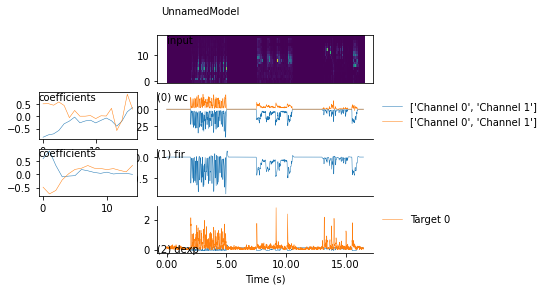

In [11]:
prediction = model_tf.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_tf, X_val, target=Y_val, sampling_rate=fs);

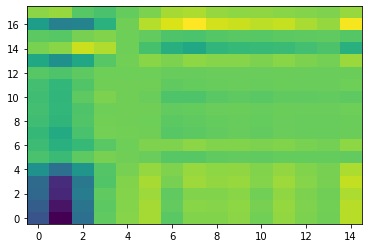

In [9]:
visualization.model.simple_strf(model_tf);

In [11]:
modelspec = 'wc.18x2-fir.15x2-lvl.1'


In [12]:
reps=20
cc0=np.zeros(reps)
cc=np.zeros(reps)
nmse=np.zeros(reps)
save_model=[]
for i in range(reps):
    #model = copy.deepcopy(model0)
    model = Model.from_keywords(modelspec)
    model.name = modelspec
    model.sample_from_priors();
    prediction0 = model.predict(X_val)
    cc0[i] = np.corrcoef(prediction0[:, 0], Y_val[:, 0])[0, 1]
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
                      'early_stopping_tolerance': 5e-4, 'validation_split': 0.0, 
                      'learning_rate': 5e-3, 'epochs': 2000}

    # Trying a TF fit:
    #model.layers[-1].skip_nonlinearity()
    #model = model.fit(input=np.expand_dims(X_est, axis=0),
    #          target=np.expand_dims(Y_est, axis=0), backend='tf',
    #          fitter_options=fitter_options,
    #          batch_size=None)
    
    #model.layers[-1].unskip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    cc[i] = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y_val) / np.std(Y_val)
    save_model.append(model)
    

TF model built...
Model: "wc.18x2-fir.15x2-lvl.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 2)          36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         30        
 F)                                                              
                                                                 
 lvl (StaticNonlinearityTF)  (None, 49500, 1)          1         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
1/1 [==============================] - 0s 294ms/step - loss: 0.9997
Epoch 2/20

1/1 [==============================] - 0s 7ms/step - loss: 0.8187
Epoch 91/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8182
Epoch 92/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8178
Epoch 93/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8174
Epoch 94/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8169
Epoch 95/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8165
Epoch 96/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8161
Epoch 97/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8158
Epoch 98/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8154
Epoch 99/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8151
Epoch 100/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8147
Epoch 101/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8144
Epoch 102/2000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 0.9380
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9294
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9208
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9124
Epoch 13/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9041
Epoch 14/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8962
Epoch 15/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8889
Epoch 16/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8821
Epoch 17/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8762
Epoch 18/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8713
Epoch 19/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8674
Epoch 20/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8647
Epoch 21/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.8120
Epoch 112/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8118
Epoch 113/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8116
Epoch 114/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8115
Epoch 115/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8113
Epoch 116/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8112
Epoch 117/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8110
Epoch 118/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8109
Epoch 119/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8108
Epoch 120/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8106
Epoch 121/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8105
Epoch 122/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8104
Epoch 123/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.8544
Epoch 32/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8526
Epoch 33/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8509
Epoch 34/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8493
Epoch 35/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8479
Epoch 36/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8466
Epoch 37/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8456
Epoch 38/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8447
Epoch 39/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8439
Epoch 40/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8433
Epoch 41/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8427
Epoch 42/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8422
Epoch 43/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.8091
Epoch 134/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8090
Epoch 135/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8089
Epoch 136/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8088
Epoch 137/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8088
Epoch 138/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8087
Epoch 139/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8086
Epoch 140/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8085
Epoch 141/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8084
Epoch 142/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8083
Epoch 143/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8082
Epoch 144/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8082
Epoch 145/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.8364
Epoch 54/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8359
Epoch 55/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8354
Epoch 56/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8349
Epoch 57/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8345
Epoch 58/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8341
Epoch 59/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8336
Epoch 60/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8332
Epoch 61/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8328
Epoch 62/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8323
Epoch 63/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8319
Epoch 64/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8315
Epoch 65/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.8075
Epoch 155/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8075
Epoch 156/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8074
Epoch 157/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8074
Epoch 158/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 159/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 160/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8072
Epoch 161/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8072
Epoch 162/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8071
Epoch 163/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8071
Epoch 164/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8070
Epoch 165/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8070
Epoch 166/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8265
Epoch 75/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8260
Epoch 76/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8256
Epoch 77/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8251
Epoch 78/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8246
Epoch 79/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8241
Epoch 80/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8236
Epoch 81/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8231
Epoch 82/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8226
Epoch 83/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8220
Epoch 84/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8215
Epoch 85/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8210
Epoch 86/2000
1/1 [==============================] - 0

Epoch 1/2000
1/1 [==============================] - 0s 261ms/step - loss: 0.9997
Epoch 2/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9930
Epoch 3/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9860
Epoch 4/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9786
Epoch 5/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9709
Epoch 6/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9630
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9548
Epoch 8/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9465
Epoch 9/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9380
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9294
Epoch 11/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9208
Epoch 12/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9124
Epoch 13/2000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 0.8138
Epoch 104/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8136
Epoch 105/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8133
Epoch 106/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8131
Epoch 107/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8128
Epoch 108/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8126
Epoch 109/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8124
Epoch 110/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8122
Epoch 111/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8120
Epoch 112/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8118
Epoch 113/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8116
Epoch 114/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8115
Epoch 115/2000
1/1 [======================

Epoch 23/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8617
Epoch 24/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8616
Epoch 25/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8615
Epoch 26/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8611
Epoch 27/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8604
Epoch 28/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8593
Epoch 29/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8579
Epoch 30/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8562
Epoch 31/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8544
Epoch 32/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8526
Epoch 33/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8509
Epoch 34/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8493
Epoch 35/2000
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 0.8100
Epoch 126/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8099
Epoch 127/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8098
Epoch 128/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8097
Epoch 129/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8096
Epoch 130/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8094
Epoch 131/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8093
Epoch 132/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8092
Epoch 133/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8091
Epoch 134/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8090
Epoch 135/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8089
Epoch 136/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8088
Epoch 137/2000
1/1 [=======================

1/1 [==============================] - 0s 9ms/step - loss: 0.8408
Epoch 46/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8403
Epoch 47/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8397
Epoch 48/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8392
Epoch 49/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8386
Epoch 50/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8381
Epoch 51/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8375
Epoch 52/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8369
Epoch 53/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8364
Epoch 54/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8359
Epoch 55/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8354
Epoch 56/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8349
Epoch 57/2000
1/1 [==============================] - 0

Epoch 147/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8080
Epoch 148/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8079
Epoch 149/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8078
Epoch 150/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8078
Epoch 151/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8077
Epoch 152/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8076
Epoch 153/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8076
Epoch 154/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8075
Epoch 155/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8075
Epoch 156/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8074
Epoch 157/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8074
Epoch 158/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 159/2000
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 0.8300
Epoch 68/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8295
Epoch 69/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8290
Epoch 70/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8285
Epoch 71/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8280
Epoch 72/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8275
Epoch 73/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8270
Epoch 74/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8265
Epoch 75/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8260
Epoch 76/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8256
Epoch 77/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8251
Epoch 78/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8246
Epoch 79/2000
1/1 [==============================] - 0

Epoch 00167: early stopping
TF model built...
Model: "wc.18x2-fir.15x2-lvl.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 2)          36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         30        
 F)                                                              
                                                                 
 lvl (StaticNonlinearityTF)  (None, 49500, 1)          1         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
1/1 [==============================] - 0s 268ms/st

1/1 [==============================] - 0s 8ms/step - loss: 0.8187
Epoch 91/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8182
Epoch 92/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8178
Epoch 93/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8174
Epoch 94/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8169
Epoch 95/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8165
Epoch 96/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8161
Epoch 97/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8158
Epoch 98/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8154
Epoch 99/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8151
Epoch 100/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8147
Epoch 101/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8144
Epoch 102/2000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 0.9380
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9294
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9208
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9124
Epoch 13/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9041
Epoch 14/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8962
Epoch 15/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8889
Epoch 16/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8821
Epoch 17/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8762
Epoch 18/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8713
Epoch 19/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8674
Epoch 20/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8647
Epoch 21/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.8120
Epoch 112/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8118
Epoch 113/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8116
Epoch 114/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8115
Epoch 115/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8113
Epoch 116/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8112
Epoch 117/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8110
Epoch 118/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8109
Epoch 119/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8108
Epoch 120/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8106
Epoch 121/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8105
Epoch 122/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8104
Epoch 123/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8544
Epoch 32/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8526
Epoch 33/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8509
Epoch 34/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8493
Epoch 35/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8479
Epoch 36/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8466
Epoch 37/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8456
Epoch 38/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8447
Epoch 39/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8439
Epoch 40/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8433
Epoch 41/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8427
Epoch 42/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8422
Epoch 43/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.8091
Epoch 134/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8090
Epoch 135/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8089
Epoch 136/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8088
Epoch 137/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8088
Epoch 138/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8087
Epoch 139/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8086
Epoch 140/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8085
Epoch 141/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8084
Epoch 142/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8083
Epoch 143/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8082
Epoch 144/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8082
Epoch 145/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.8364
Epoch 54/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8359
Epoch 55/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8354
Epoch 56/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8349
Epoch 57/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8345
Epoch 58/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8341
Epoch 59/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8336
Epoch 60/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8332
Epoch 61/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8328
Epoch 62/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8323
Epoch 63/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8319
Epoch 64/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8315
Epoch 65/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.8075
Epoch 155/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8075
Epoch 156/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8074
Epoch 157/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8074
Epoch 158/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 159/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 160/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8072
Epoch 161/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8072
Epoch 162/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8071
Epoch 163/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8071
Epoch 164/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8070
Epoch 165/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8070
Epoch 166/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.8265
Epoch 75/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8260
Epoch 76/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8256
Epoch 77/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8251
Epoch 78/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8246
Epoch 79/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8241
Epoch 80/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8236
Epoch 81/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8231
Epoch 82/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8226
Epoch 83/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8220
Epoch 84/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8215
Epoch 85/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8210
Epoch 86/2000
1/1 [==============================] - 0

Epoch 1/2000
1/1 [==============================] - 0s 263ms/step - loss: 0.9997
Epoch 2/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9930
Epoch 3/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9860
Epoch 4/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.9786
Epoch 5/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9709
Epoch 6/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9630
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9548
Epoch 8/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9465
Epoch 9/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9380
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9294
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9208
Epoch 12/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9124
Epoch 13/2000
1/1 [============================

1/1 [==============================] - 0s 8ms/step - loss: 0.8138
Epoch 104/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8136
Epoch 105/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8133
Epoch 106/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8131
Epoch 107/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8128
Epoch 108/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8126
Epoch 109/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8124
Epoch 110/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8122
Epoch 111/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8120
Epoch 112/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8118
Epoch 113/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8116
Epoch 114/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8115
Epoch 115/2000
1/1 [======================

Epoch 23/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8617
Epoch 24/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8616
Epoch 25/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8615
Epoch 26/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8611
Epoch 27/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8604
Epoch 28/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8593
Epoch 29/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8579
Epoch 30/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8562
Epoch 31/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8544
Epoch 32/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8526
Epoch 33/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8509
Epoch 34/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8493
Epoch 35/2000
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 0.8100
Epoch 126/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8099
Epoch 127/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8098
Epoch 128/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8097
Epoch 129/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8096
Epoch 130/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8094
Epoch 131/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8093
Epoch 132/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8092
Epoch 133/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8091
Epoch 134/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8090
Epoch 135/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8089
Epoch 136/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8088
Epoch 137/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8408
Epoch 46/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8403
Epoch 47/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8397
Epoch 48/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8392
Epoch 49/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8386
Epoch 50/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8381
Epoch 51/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8375
Epoch 52/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8369
Epoch 53/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8364
Epoch 54/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8359
Epoch 55/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8354
Epoch 56/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8349
Epoch 57/2000
1/1 [==============================] - 0

Epoch 147/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8080
Epoch 148/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8079
Epoch 149/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8078
Epoch 150/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8078
Epoch 151/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8077
Epoch 152/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8076
Epoch 153/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8076
Epoch 154/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8075
Epoch 155/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8075
Epoch 156/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8074
Epoch 157/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8074
Epoch 158/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8073
Epoch 159/2000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 0.8300
Epoch 68/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8295
Epoch 69/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8290
Epoch 70/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8285
Epoch 71/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8280
Epoch 72/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8275
Epoch 73/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8270
Epoch 74/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8265
Epoch 75/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8260
Epoch 76/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8256
Epoch 77/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8251
Epoch 78/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8246
Epoch 79/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 0.8069
Epoch 00167: early stopping
TF model built...
Model: "wc.18x2-fir.15x2-lvl.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 2)          36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         30        
 F)                                                              
                                                                 
 lvl (StaticNonlinearityTF)  (None, 49500, 1)          1         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
N

1/1 [==============================] - 0s 8ms/step - loss: 0.8191
Epoch 90/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8187
Epoch 91/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8182
Epoch 92/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8178
Epoch 93/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8174
Epoch 94/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8169
Epoch 95/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8165
Epoch 96/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8161
Epoch 97/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8158
Epoch 98/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8154
Epoch 99/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8151
Epoch 100/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8147
Epoch 101/2000
1/1 [==============================] -

1/1 [==============================] - 0s 6ms/step - loss: 0.9465
Epoch 9/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9380
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9294
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9208
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9124
Epoch 13/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9041
Epoch 14/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8962
Epoch 15/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8889
Epoch 16/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8821
Epoch 17/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8762
Epoch 18/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8713
Epoch 19/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8674
Epoch 20/2000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.8122
Epoch 111/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8120
Epoch 112/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8118
Epoch 113/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8116
Epoch 114/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8115
Epoch 115/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8113
Epoch 116/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8112
Epoch 117/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8110
Epoch 118/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8109
Epoch 119/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8108
Epoch 120/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8106
Epoch 121/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8105
Epoch 122/2000
1/1 [=======================

In [13]:
cc0,cc,nmse

(array([0.44348662, 0.44348662, 0.44348662, 0.44348662, 0.44348662,
        0.44348662, 0.44348662, 0.44348662, 0.44348662, 0.44348662,
        0.44348662, 0.44348662, 0.44348662, 0.44348662, 0.44348662,
        0.44348662, 0.44348662, 0.44348662, 0.44348662, 0.44348662]),
 array([0.58931071, 0.58931071, 0.58931071, 0.58931071, 0.58931072,
        0.58931071, 0.58931072, 0.58931072, 0.58931072, 0.58931071,
        0.58931072, 0.58931071, 0.58931072, 0.58931072, 0.58931072,
        0.58931071, 0.58931071, 0.58931071, 0.58931072, 0.58931071]),
 array([0.84025899, 0.84025899, 0.84025899, 0.84025899, 0.84025899,
        0.84025899, 0.84025899, 0.84025899, 0.84025899, 0.84025899,
        0.84025899, 0.84025899, 0.84025899, 0.84025899, 0.84025899,
        0.84025899, 0.84025899, 0.84025899, 0.84025899, 0.84025899]))

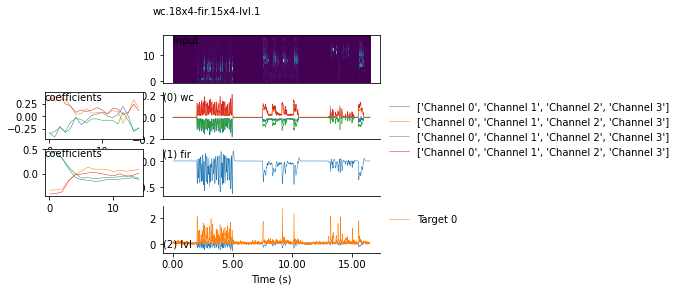

In [139]:
visualization.model.plot_model_with_parameters(
        save_model[-1], X_val, target=Y_val, sampling_rate=fs);

In [39]:
X_est.shape,Y_est.shape,X_val.shape,Y_val.shape

((49500, 18), (49500, 1), (1650, 18), (1650, 1))

In [27]:
X.shape,Y.shape

((2000, 2), (2000, 1))

In [79]:
X=np.random.randn(500,2)
Y = X[:,:1]/2 + np.random.randn(X.shape[0],1)/100

#modelspec = 'wc.2x2-wc.2x1'   # works fine
#modelspec = 'wc.2x2-fir.1x2'   # gives sign flip
modelspec = 'fir.1x2'   # behaves weirdly

reps=5
cc=np.zeros(reps)
nmse=np.zeros(reps)
save_models0=[]
save_models=[]

for i in range(reps):
    model = Model.from_keywords(modelspec)
    model.sample_from_priors();
    save_models0.append(copy.deepcopy(model))
    
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 1e-2, 'epochs': 1000}
    model = model.fit(input=np.expand_dims(X, axis=0),
              target=np.expand_dims(Y, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # uncomment to run in scipy -- works fine
    #fitter_options={'cost_function': 'nmse', 'options': {'ftol': 1e-5, 'maxiter': 100}}
    #model=model.fit(input=X, target=Y, backend='scipy',
    #          fitter_options=fitter_options)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X)
    cc[i] = np.corrcoef(prediction[:, 0], Y[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y) / np.std(Y)
    save_models.append(model)
cc,nmse

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 500, 2)]          0         
                                                                 
 fir (FiniteImpulseResponseT  (None, 500, 1)           2         
 F)                                                              
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [==============================] - 0s 204ms/step - loss: 1.7815
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7610
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 1.7407
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.7206
Epoch 5/1000
1/1 [==============================]

1/1 [==============================] - 0s 5ms/step - loss: 1.5350
Epoch 69/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.5127
Epoch 70/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.4904
Epoch 71/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.4683
Epoch 72/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.4463
Epoch 73/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.4244
Epoch 74/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.4025
Epoch 75/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.3807
Epoch 76/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.3590
Epoch 77/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.3374
Epoch 78/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.3159
Epoch 79/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2944
Epoch 80/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 109/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 110/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 111/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 112/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0202
Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 500, 2)]          0         
                                                                 
 fir (FiniteImpulseResponseT  (None, 500, 1)           2         
 F)                                                              
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
____________________

Epoch 63/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 64/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0263
Epoch 65/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 66/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 67/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0206
Epoch 68/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 69/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0202
Epoch 70/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 71/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 72/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 73/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 74/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0214
Epoch 75/1000
1/1 [=====================

(array([0.0269035 , 0.02634863, 0.02579964, 0.0256707 , 0.02780842]),
 array([1.38791863, 1.4080504 , 1.38758967, 1.39336053, 1.39099635]))

In [39]:
X_est.shape,Y_est.shape,X_val.shape,Y_val.shape

((49500, 18), (49500, 1), (1650, 18), (1650, 1))

In [80]:
cc,nmse

(array([0.0269035 , 0.02634863, 0.02579964, 0.0256707 , 0.02780842]),
 array([1.38791863, 1.4080504 , 1.38758967, 1.39336053, 1.39099635]))

In [76]:
for i in range(len(save_models)):
    print(i, save_models0[i].layers[0].coefficients.T, "-->", save_models[i].layers[0].coefficients.T)
    #print(i, save_models0[i].layers[2].coefficients.T, "-->", save_models[i].layers[2].coefficients.T)
    

0 [[-0.32520574]
 [-0.01180694]] --> [[0.00125205]
 [0.50231379]]
1 [[-0.65965301]
 [-0.37315592]] --> [[-0.00075746]
 [ 0.49859866]]
2 [[-0.26193442]
 [ 0.58569514]] --> [[-9.18854639e-05]
 [ 5.00135958e-01]]
3 [[0.01577722]
 [1.03535215]] --> [[0.00060694]
 [0.49899769]]
4 [[-1.08091311]
 [-1.18122413]] --> [[-0.00186215]
 [ 0.5079419 ]]


In [68]:
#modelspec = 'wc.1x2-fir.1x2'
modelspec = 'fir.1x3'


In [23]:
X=np.random.randn(3000,3)
#X[:,1:]=100
Y = X[:,:1]/2 + np.random.randn(X.shape[0],1)/100+0.5

modelspec = 'wc.3x1-fir.2x1-lvl.1'
reps=2
cc=np.zeros(reps)
nmse=np.zeros(reps)
save_models0=[]
save_models=[]
for i in range(reps):
    model = Model.from_keywords(modelspec)
    model.sample_from_priors();
    save_models0.append(copy.deepcopy(model))
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-5, 'validation_split': 0.0,
              'learning_rate': 1e-3, 'epochs': 1000}

    model = model.fit(input=np.expand_dims(X, axis=0),
              target=np.expand_dims(X, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    #fitter_options={'cost_function': 'nmse', 'options': {'gtol': 1e-9, 'maxiter': 100}}
    #model=model.fit(input=X, target=X, backend='scipy',
    #          fitter_options=fitter_options)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X)
    cc[i] = np.corrcoef(prediction[:, 0], Y[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y) / np.std(Y)
    save_models.append(model)

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3000, 3)]         0         
                                                                 
 wc (WeightChannelsTF)       (None, 3000, 1)           3         
                                                                 
 fir (FiniteImpulseResponseT  (None, 3000, 1)          2         
 F)                                                              
                                                                 
 lvl (StaticNonlinearityTF)  (None, 3000, 1)           1         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [==============================] - 0s 272ms/step - loss: 1.0110
Epoch 2/1000
1/1 [====

1/1 [==============================] - 0s 7ms/step - loss: 0.9336
Epoch 192/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9331
Epoch 193/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9325
Epoch 194/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9319
Epoch 195/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9313
Epoch 196/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9308
Epoch 197/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.9302
Epoch 198/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9296
Epoch 199/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9290
Epoch 200/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9285
Epoch 201/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9279
Epoch 202/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9273
Epoch 203/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8375
Epoch 394/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8373
Epoch 395/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8371
Epoch 396/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8369
Epoch 397/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8367
Epoch 398/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8365
Epoch 399/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8363
Epoch 400/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8361
Epoch 401/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8359
Epoch 402/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8357
Epoch 403/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8356
Epoch 404/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8354
Epoch 405/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 596/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8245
Epoch 597/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 598/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8245
Epoch 599/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 600/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8245
Epoch 601/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 602/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8245
Epoch 603/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 604/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8245
Epoch 605/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8245
Epoch 606/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8245
Epoch 607/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.9776
Epoch 60/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9771
Epoch 61/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9766
Epoch 62/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9760
Epoch 63/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9755
Epoch 64/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9750
Epoch 65/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9744
Epoch 66/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9739
Epoch 67/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9733
Epoch 68/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9728
Epoch 69/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9723
Epoch 70/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9717
Epoch 71/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.8558
Epoch 262/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8553
Epoch 263/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8549
Epoch 264/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8545
Epoch 265/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8541
Epoch 266/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8537
Epoch 267/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8533
Epoch 268/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8529
Epoch 269/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8525
Epoch 270/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8521
Epoch 271/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8517
Epoch 272/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8513
Epoch 273/1000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.8253
Epoch 464/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8253
Epoch 465/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8253
Epoch 466/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8252
Epoch 467/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8252
Epoch 468/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8252
Epoch 469/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8252
Epoch 470/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8252
Epoch 471/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8252
Epoch 472/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8251
Epoch 473/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8251
Epoch 474/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.8251
Epoch 475/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 666/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8242
Epoch 667/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 668/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8242
Epoch 669/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8242
Epoch 670/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 671/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 672/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 673/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.8242
Epoch 674/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8242
Epoch 675/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8242
Epoch 676/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 677/1000
1/1 [=======================

In [12]:
cc,nmse

(array([0.68197792, 0.63321614, 0.69601732, 0.73447597, 0.65802949]),
 array([1.02660443, 1.09656587, 1.0037761 , 0.95601944, 1.08339952]))

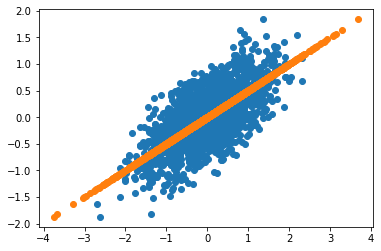

In [13]:
import matplotlib.pyplot as plt
plt.scatter(prediction,Y)
plt.scatter(X[:,0],Y)

In [14]:
for i in range(len(save_models)):
    print(save_models0[i].layers[0].coefficients.T)
    print(save_models[i].layers[0].coefficients.T)

[[0.06535807 0.00602316]]
[[-0.53017294 -0.58936685]]
[[ 0.10237922 -0.03779126]]
[[-0.49912685 -0.6354475 ]]
[[ 0.03791855 -0.00414203]]
[[-0.63081264 -0.67367589]]
[[0.04092904 0.0081244 ]]
[[0.61329281 0.58460289]]
[[-0.09877262 -0.04658165]]
[[0.2833406  0.33686575]]


In [166]:
model.backend.predict(np.expand_dims(X, axis=0)).shape

(1, 1000, 1)

In [152]:
X_est=np.random.randn(1000,2)
Y_est = X_est[:,0:1]/2-X_est[:,1:2]/2+np.random.randn(X_est.shape[0],1)/100 + 0.05
Y_est=Y_est*(Y_est>0)
X_val=np.random.randn(500,2)
Y_val = X_val[:,0:1]/2-X_val[:,1:2]/2+np.random.randn(X_val.shape[0],1)/100 + 0.05
#Y_val=Y_val*(Y_val>0)

modelspec = 'wc.2x2-fir.1x2-lvl.1'
model0 = Model.from_keywords(modelspec)


In [153]:
reps=20
cc0=np.zeros(reps)
cc=np.zeros(reps)
nmse=np.zeros(reps)

for i in range(reps):
    #model = copy.deepcopy(model0)
    model = Model.from_keywords(modelspec)
    model.sample_from_priors();
    prediction0 = model.predict(X_val)
    cc0[i] = np.corrcoef(prediction0[:, 0], Y_val[:, 0])[0, 1]
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 1e-3, 'epochs': 1000}

    # Trying a TF fit:
    #model.layers[-1].skip_nonlinearity()
    #model = model.fit(input=np.expand_dims(X_est, axis=0),
    #          target=np.expand_dims(Y_est, axis=0), backend='tf',
    #          fitter_options=fitter_options,
    #          batch_size=None)
    #
    #model.layers[-1].unskip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_est)
    cc[i] = np.corrcoef(prediction[:, 0], Y_est[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y_est) / np.std(Y_est)
    

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 2)]         0         
                                                                 
 wc (WeightChannelsTF)       (None, 1000, 2)           4         
                                                                 
 fir (FiniteImpulseResponseT  (None, 1000, 1)          2         
 F)                                                              
                                                                 
 lvl (StaticNonlinearityTF)  (None, 1000, 1)           1         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None
<function loss_tf_nmse at 0x7f83f9386b80>
Epoch 1/1000
1/1 [==============================] - 0s 273ms/

1/1 [==============================] - 0s 6ms/step - loss: 0.8356
Epoch 91/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8330
Epoch 92/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8303
Epoch 93/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8276
Epoch 94/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8249
Epoch 95/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8222
Epoch 96/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8195
Epoch 97/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8167
Epoch 98/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8140
Epoch 99/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8112
Epoch 100/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8084
Epoch 101/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8056
Epoch 102/1000
1/1 [==============================] 

1/1 [==============================] - 0s 6ms/step - loss: 0.4107
Epoch 293/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4105
Epoch 294/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4102
Epoch 295/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4100
Epoch 296/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4098
Epoch 297/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4096
Epoch 298/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4094
Epoch 299/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4092
Epoch 300/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4090
Epoch 301/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4089
Epoch 302/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4087
Epoch 303/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4085
Epoch 304/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.6204
Epoch 143/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6177
Epoch 144/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6150
Epoch 145/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6123
Epoch 146/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6097
Epoch 147/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6070
Epoch 148/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6044
Epoch 149/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.6017
Epoch 150/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5991
Epoch 151/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5965
Epoch 152/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.5939
Epoch 153/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5913
Epoch 154/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.4059
Epoch 345/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4058
Epoch 346/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4057
Epoch 347/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4056
Epoch 348/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4055
Epoch 349/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4054
Epoch 350/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4053
Epoch 351/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4052
Epoch 352/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4051
Epoch 353/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4050
Epoch 354/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4050
Epoch 355/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4049
Epoch 356/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.4779
Epoch 176/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4769
Epoch 177/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4759
Epoch 178/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4750
Epoch 179/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4740
Epoch 180/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4731
Epoch 181/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4722
Epoch 182/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4712
Epoch 183/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4703
Epoch 184/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4694
Epoch 185/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4685
Epoch 186/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4677
Epoch 187/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 1.0152
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0130
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0108
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0085
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0063
Epoch 9/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0041
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0019
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9996
Epoch 12/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9974
Epoch 13/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9952
Epoch 14/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9930
Epoch 15/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9908
Epoch 16/1000
1/1 [==============================] - 0s 5ms

1/1 [==============================] - 0s 8ms/step - loss: 0.4967
Epoch 208/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4945
Epoch 209/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4924
Epoch 210/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4903
Epoch 211/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4883
Epoch 212/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4862
Epoch 213/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4843
Epoch 214/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4823
Epoch 215/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4804
Epoch 216/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4785
Epoch 217/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4766
Epoch 218/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4748
Epoch 219/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.8405
Epoch 58/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8373
Epoch 59/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8340
Epoch 60/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8307
Epoch 61/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8275
Epoch 62/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8242
Epoch 63/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8209
Epoch 64/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8176
Epoch 65/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8143
Epoch 66/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8110
Epoch 67/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8077
Epoch 68/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8044
Epoch 69/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.4266
Epoch 260/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4261
Epoch 261/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4257
Epoch 262/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4253
Epoch 263/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4249
Epoch 264/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4245
Epoch 265/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4241
Epoch 266/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4237
Epoch 267/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4233
Epoch 268/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4230
Epoch 269/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4226
Epoch 270/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4222
Epoch 271/1000
1/1 [=======================

Epoch 1/1000
1/1 [==============================] - 0s 245ms/step - loss: 1.0065
Epoch 2/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0037
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.0008
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9980
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9951
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9923
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9894
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9866
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9837
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9809
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9781
Epoch 12/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9752
Epoch 13/1000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 0.4789
Epoch 205/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4774
Epoch 206/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4760
Epoch 207/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4746
Epoch 208/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4732
Epoch 209/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4719
Epoch 210/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4705
Epoch 211/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4692
Epoch 212/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4679
Epoch 213/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4666
Epoch 214/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4654
Epoch 215/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4642
Epoch 216/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.9318
Epoch 36/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9299
Epoch 37/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9280
Epoch 38/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9261
Epoch 39/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9241
Epoch 40/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9222
Epoch 41/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9203
Epoch 42/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9183
Epoch 43/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9164
Epoch 44/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9144
Epoch 45/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9125
Epoch 46/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9105
Epoch 47/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.6715
Epoch 138/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6684
Epoch 139/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6653
Epoch 140/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6623
Epoch 141/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6592
Epoch 142/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6561
Epoch 143/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6530
Epoch 144/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6499
Epoch 145/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6468
Epoch 146/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6437
Epoch 147/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6407
Epoch 148/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6376
Epoch 149/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.4062
Epoch 340/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4061
Epoch 341/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4060
Epoch 342/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4059
Epoch 343/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4058
Epoch 344/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4056
Epoch 345/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4055
Epoch 346/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4054
Epoch 347/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4053
Epoch 348/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4052
Epoch 349/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4051
Epoch 350/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4050
Epoch 351/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.8425
Epoch 66/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8400
Epoch 67/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8374
Epoch 68/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8348
Epoch 69/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8323
Epoch 70/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8297
Epoch 71/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8271
Epoch 72/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8245
Epoch 73/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8219
Epoch 74/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8193
Epoch 75/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8167
Epoch 76/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8141
Epoch 77/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.4349
Epoch 268/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4343
Epoch 269/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4336
Epoch 270/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4329
Epoch 271/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4323
Epoch 272/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4316
Epoch 273/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4310
Epoch 274/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4304
Epoch 275/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4298
Epoch 276/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4292
Epoch 277/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4286
Epoch 278/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4280
Epoch 279/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.7943
Epoch 87/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7915
Epoch 88/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7887
Epoch 89/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7859
Epoch 90/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7831
Epoch 91/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7803
Epoch 92/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7774
Epoch 93/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7745
Epoch 94/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7717
Epoch 95/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7688
Epoch 96/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.7658
Epoch 97/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7629
Epoch 98/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.4113
Epoch 289/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4111
Epoch 290/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4109
Epoch 291/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4107
Epoch 292/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4105
Epoch 293/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4103
Epoch 294/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4101
Epoch 295/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4099
Epoch 296/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4097
Epoch 297/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4095
Epoch 298/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4093
Epoch 299/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4091
Epoch 300/1000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.7082
Epoch 140/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7056
Epoch 141/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7030
Epoch 142/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7004
Epoch 143/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6977
Epoch 144/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6951
Epoch 145/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6925
Epoch 146/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898
Epoch 147/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6872
Epoch 148/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6845
Epoch 149/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6818
Epoch 150/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6792
Epoch 151/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.4084
Epoch 342/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4083
Epoch 343/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4081
Epoch 344/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4080
Epoch 345/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4078
Epoch 346/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4077
Epoch 347/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4075
Epoch 348/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4074
Epoch 349/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4072
Epoch 350/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4071
Epoch 351/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4070
Epoch 352/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4068
Epoch 353/1000
1/1 [=======================

Epoch 53/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8670
Epoch 54/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8646
Epoch 55/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8622
Epoch 56/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8598
Epoch 57/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8573
Epoch 58/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8549
Epoch 59/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8524
Epoch 60/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8499
Epoch 61/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8474
Epoch 62/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8449
Epoch 63/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8424
Epoch 64/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8399
Epoch 65/1000
1/1 [=====================

1/1 [==============================] - 0s 7ms/step - loss: 0.4214
Epoch 256/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4210
Epoch 257/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4206
Epoch 258/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4202
Epoch 259/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4198
Epoch 260/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4194
Epoch 261/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4190
Epoch 262/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4186
Epoch 263/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4183
Epoch 264/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4179
Epoch 265/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4176
Epoch 266/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4172
Epoch 267/1000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.6625
Epoch 104/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6595
Epoch 105/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6564
Epoch 106/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6534
Epoch 107/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6503
Epoch 108/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6473
Epoch 109/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6443
Epoch 110/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6413
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6383
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6353
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6323
Epoch 114/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6293
Epoch 115/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.4077
Epoch 306/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4076
Epoch 307/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4075
Epoch 308/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4073
Epoch 309/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4072
Epoch 310/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4071
Epoch 311/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4069
Epoch 312/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4068
Epoch 313/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4067
Epoch 314/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4065
Epoch 315/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4064
Epoch 316/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4063
Epoch 317/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.8733
Epoch 63/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8707
Epoch 64/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8681
Epoch 65/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8655
Epoch 66/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8629
Epoch 67/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8602
Epoch 68/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8576
Epoch 69/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8549
Epoch 70/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8522
Epoch 71/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8495
Epoch 72/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8468
Epoch 73/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8441
Epoch 74/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.4300
Epoch 265/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4294
Epoch 266/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4287
Epoch 267/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4281
Epoch 268/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4275
Epoch 269/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4269
Epoch 270/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4263
Epoch 271/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4257
Epoch 272/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4251
Epoch 273/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4246
Epoch 274/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4240
Epoch 275/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4235
Epoch 276/1000
1/1 [=======================

Epoch 1/1000
1/1 [==============================] - 0s 244ms/step - loss: 0.9675
Epoch 2/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9639
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9602
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9566
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9530
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9494
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.9457
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9421
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9385
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9349
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9313
Epoch 12/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9277
Epoch 13/1000
1/1 [============================

1/1 [==============================] - 0s 6ms/step - loss: 0.4561
Epoch 205/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4553
Epoch 206/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4544
Epoch 207/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4536
Epoch 208/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4529
Epoch 209/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4521
Epoch 210/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4513
Epoch 211/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4505
Epoch 212/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4498
Epoch 213/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4490
Epoch 214/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4483
Epoch 215/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4476
Epoch 216/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.7995
Epoch 44/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7959
Epoch 45/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7922
Epoch 46/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7886
Epoch 47/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7850
Epoch 48/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7814
Epoch 49/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7777
Epoch 50/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7742
Epoch 51/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7706
Epoch 52/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7670
Epoch 53/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7634
Epoch 54/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.7598
Epoch 55/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.5210
Epoch 146/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5195
Epoch 147/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5180
Epoch 148/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5166
Epoch 149/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5152
Epoch 150/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5138
Epoch 151/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5124
Epoch 152/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5111
Epoch 153/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5097
Epoch 154/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5084
Epoch 155/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5071
Epoch 156/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5058
Epoch 157/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.4065
Epoch 348/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4064
Epoch 349/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4063
Epoch 350/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4062
Epoch 351/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4061
Epoch 352/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4060
Epoch 353/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4059
Epoch 354/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4058
Epoch 355/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4057
Epoch 356/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4056
Epoch 357/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4055
Epoch 00357: early stopping
TF model built...
Model: "UnnamedModel"
________________________________________________________

1/1 [==============================] - 0s 8ms/step - loss: 0.4822
Epoch 179/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4806
Epoch 180/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4791
Epoch 181/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4777
Epoch 182/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4762
Epoch 183/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4748
Epoch 184/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4734
Epoch 185/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4721
Epoch 186/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4707
Epoch 187/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4694
Epoch 188/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4681
Epoch 189/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4669
Epoch 190/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.9911
Epoch 26/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9895
Epoch 27/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9878
Epoch 28/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9862
Epoch 29/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9845
Epoch 30/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9829
Epoch 31/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9813
Epoch 32/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9797
Epoch 33/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9781
Epoch 34/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9765
Epoch 35/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9749
Epoch 36/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9733
Epoch 37/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.5602
Epoch 229/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5572
Epoch 230/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5542
Epoch 231/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5512
Epoch 232/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5482
Epoch 233/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5453
Epoch 234/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5424
Epoch 235/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5394
Epoch 236/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5365
Epoch 237/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5336
Epoch 238/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5308
Epoch 239/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5279
Epoch 240/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.8660
Epoch 45/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8635
Epoch 46/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8610
Epoch 47/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8585
Epoch 48/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8560
Epoch 49/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8535
Epoch 50/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8510
Epoch 51/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8485
Epoch 52/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8460
Epoch 53/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8434
Epoch 54/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8409
Epoch 55/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8383
Epoch 56/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.5796
Epoch 147/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5768
Epoch 148/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5741
Epoch 149/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5714
Epoch 150/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5688
Epoch 151/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5661
Epoch 152/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5635
Epoch 153/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5608
Epoch 154/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5582
Epoch 155/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5556
Epoch 156/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.5531
Epoch 157/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5505
Epoch 158/1000
1/1 [=======================

Epoch 1/1000
1/1 [==============================] - 0s 258ms/step - loss: 1.0193
Epoch 2/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0168
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0143
Epoch 4/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0118
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0092
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0067
Epoch 7/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0042
Epoch 8/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.0017
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9992
Epoch 10/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9967
Epoch 11/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9942
Epoch 12/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9917
Epoch 13/1000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 0.4710
Epoch 205/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4696
Epoch 206/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4682
Epoch 207/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4668
Epoch 208/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4655
Epoch 209/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4642
Epoch 210/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4629
Epoch 211/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4617
Epoch 212/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4605
Epoch 213/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4593
Epoch 214/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4581
Epoch 215/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4570
Epoch 216/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.9614
Epoch 38/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9584
Epoch 39/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9555
Epoch 40/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9525
Epoch 41/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9495
Epoch 42/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9465
Epoch 43/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9435
Epoch 44/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9405
Epoch 45/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9375
Epoch 46/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9345
Epoch 47/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.9315
Epoch 48/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.9285
Epoch 49/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.4360
Epoch 241/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4353
Epoch 242/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4346
Epoch 243/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4339
Epoch 244/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4333
Epoch 245/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4326
Epoch 246/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4320
Epoch 247/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4314
Epoch 248/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4308
Epoch 249/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4302
Epoch 250/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4296
Epoch 251/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4290
Epoch 252/1000
1/1 [=======================

In [154]:
cc0,cc,nmse

(array([ 0.90431714, -0.41142332, -0.20962291, -0.40232274, -0.5198493 ,
         0.45578414, -0.99789238,  0.35562165,  0.37921182,  0.88958468,
         0.99946395,  0.71054791,  0.38743281,  0.30394038,  0.71642974,
        -0.71519968, -0.94650798, -0.79388319, -0.99557022,  0.42975843]),
 array([-0.99965014,  0.99639014, -0.9992662 , -0.99834417, -0.98851534,
         0.99981995, -0.99591774,  0.99990873, -0.99388399, -0.99952773,
         0.99985904, -0.94891304,  0.99001783,  0.99984624, -0.95006222,
        -0.99990231,  0.99761805, -0.99983937, -0.99986323,  0.9994407 ]),
 array([1.58882253, 0.52405577, 1.51524137, 1.58640685, 1.57747021,
        0.47580053, 1.5608949 , 0.4776757 , 1.57833206, 1.4609747 ,
        0.47585916, 1.48067093, 0.39594767, 0.49217232, 1.42880198,
        1.51854451, 0.51557754, 1.52623899, 1.60605887, 0.30858206]))

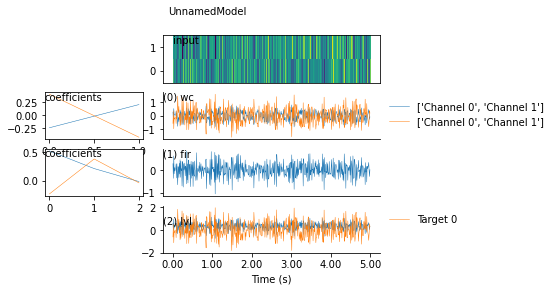

In [151]:
visualization.model.plot_model_with_parameters(
        model, X_val, target=Y_val, sampling_rate=fs);